# Analysing Face Detection on African data

### Importing Libraries

In [1]:
import gc
import os
import sys
import math
import glob
import tqdm
import random
import numpy as np
from tqdm import tqdm
from time import sleep

In [2]:
import pandas as pd
import xml.etree.ElementTree as ET

In [3]:
import cv2
import dlib
from imutils import face_utils
from skimage.feature import hog
from skimage import data,exposure

In [4]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from ipywidgets import widgets, interactive, fixed

### Defining Paths

#### Path to Data Folder

In [6]:
path_folder_bagamoyo_data = '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/'

#### Path to Frames

In [7]:
path_folder_all_frames = path_folder_bagamoyo_data + '/bagamoyo_frames_all_in_one/'

In [8]:
path_folder_wise_frames = path_folder_bagamoyo_data + '/bagamoyo_frames_folder_wise/'

#### Path to xml files

In [9]:
!ls

data-analysis-Copy1.ipynb	  README.md
data-analysis.ipynb		  scripts
Generate-xml-dlib.ipynb		  shape_predictor_68_face_landmarks.dat
mmod_human_face_detector.dat	  train_dlib_detector.py
mmod_human_face_detector.dat.bz2  ZFace label analysis.ipynb
output_XML


comment: will change

In [10]:
path_xml_file = 'training.xml'

## Analysis 

1. Absolute - Find the number of frames in total in which face is detected, and how many in each frame
2. Check continuity - a visualisation for seeing which frames in the continuity.
3. This can be done by writing a single script which does these things if an xml file is generated with the name of the image and the coordinates of the bounding boxes in it.

#### Parsing XML file

In [11]:
def getDataframeFromXML(path_file_xml):
    """
    Returns the dataframe(columns- videoName,frameNo,faceNo,left,right,width,height) from given xml file path holding bounding boxes for each frame.
    
    Parameters
    ----------
    path_file_xml : path of the XML file.
    
    Returns
    -------
    Pandas dataframe
        Information about images and their boxes.
    """
    
    #make a new dataframe to store the data.
    df = pd.DataFrame(columns=['name_image','name_video','num_frame','num_box','left','top','width','height'])
    
    #parsing XML and populating dataframe
    tree = ET.parse(path_file_xml)
    root = tree.getroot()
    for image in tqdm(root.iter('image')):
        name_file = image.attrib['file']
        name_video = name_file.split('.')[0].rsplit(' ',1)[0]
        num_frame = (int)(name_file.split('.')[0].rsplit(' ',1)[1])
        
        #if no box, box attributes are np.nan
        if (len(image) == 0):
            row_data = [name_file, name_video, num_frame, np.nan, np.nan, np.nan, np.nan, np.nan]
            df.loc[len(df)] = row_data
        else:
            for box_num,box in enumerate(image):
                box_attribs = box.attrib
                row_data = [name_file, name_video, num_frame, box_num+1, box_attribs['left'], box_attribs['top'],box_attribs['width'],box_attribs['height']]
                df.loc[len(df)] = row_data
    return df
    

In [12]:
def getDictVideoBoxesPerFrameFromXML(path_file_xml):
    """
    Returns a dictionary of form {video_name:[(frame_no,no_of_boxes),(frame_no+1,no_of_boxes),(frame_no+2,no_of_boxes)]} given the path of XML file
    """
    
    result = {}
    #parsing XML and generating dictionary
    tree = ET.parse(path_file_xml)
    root = tree.getroot()
    for image in tqdm(root.iter('image')):
        name_file = image.attrib['file']
        name_video = name_file.split('.')[0].rsplit(' ',1)[0]
        num_frame = (int)(name_file.split('.')[0].rsplit(' ',1)[1])
        num_boxes = len(image)
        if name_video in result:
            result[name_video].append((num_frame, num_boxes))
        else:
            result[name_video] = [(num_frame, num_boxes)]    
    return result

#### Plotting functions

In [13]:
def plotBoxesInFrames(videoName,zippedListFrameBox):
    """
    Plots the number of boxes with frame given the name of the video and corresponding zippedlist of form [(frame_no,no_of_boxes),(frame_no+1,no_of_boxes)...]
    
    Parameters
    ----------
    videoName : Name of the video.
    zippedListFrameBox : zipped list of the form [(frame_no,no_of_boxes),(frame_no+1,no_of_boxes),(frame_no+2,no_of_boxes)]
    
    Returns
    -------
    None
    """

    unzippedList = zip(*sorted(zippedListFrameBox))
    x = np.array(unzippedList[0])
    y = np.array(unzippedList[1])
    
    max_faces = max(y)
    fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

#     extent = [0, x[-1],0,max_faces]
    hm = ax.imshow(y[np.newaxis,:], cmap="PuBu", aspect="auto")
    ax.set_yticks([])
    
#     ax3 = fig.add_subplot(1,1,1)
#     color_legend=ax.pcolor([x,y])
#     ax.set_xlim(extent[0], extent[1])

    ax2.plot(x,y)
    ax2.legend([videoName],loc='center left',bbox_to_anchor=(1, 0.5))
#     ax2.set_xlim(extent[0], extent[1])
    plt.xlabel("Frame Number")
    plt.ylabel("Number of Faces Detected")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.5, 0.01, 0.4])
    cbar = fig.colorbar(hm,pad=0.2,cax=cbar_ax,format='%1i',ticks=[i for i in range(20)])
    cbar.set_label('# of faces', rotation=270)
    plt.show()

In [14]:
def plotit(video_file_name,dict_video_box_frame):
    """
    Plots the number of boxes versus frames and also the heatmap to indicate the number of faces detected.
    """
    
    plotBoxesInFrames(video_file_name,dict_video_box_frame[video_file_name])

Functions for analysis:
    
- Read XML, give complete analysis.
- See folder, give the option of comparing the data in the different XML files.


#### End to End functions (directly plot from XML)

In [15]:
def analyseFromXML(path_xml_file):
    """
    Parses the XML file given its path and plots the following statistics:
    Histogram- No of faces for each frame, heatmap for number of faces detected in each frame.
    
    """
    
    dictVideoBoxesPerFrame = getDictVideoBoxesPerFrameFromXML(path_xml_file) 
    listVideoNames=dictVideoBoxesPerFrame.keys() #to build options in dropdown.
    video_file_name = widgets.Dropdown(options=listVideoNames,description='Video File:')
    interactive_widgets = interactive(plotit,video_file_name=video_file_name, dict_video_box_frame=fixed(dictVideoBoxesPerFrame))
    display(interactive_widgets)

TODO Comparing and Analysing data from multiple sources
- Show the options of the available xml files. Show the ones that can be compared. Have an option to show only the comparable ones by a simple toggle button

## Analysing ZFace data (show)

In [16]:
analyseFromXML('output_XML/zface-output.xml')

44492it [00:00, 251833.93it/s]


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnVmlkZW8gRmlsZTonLCBvcHRpb25zPSgnVklERU9fMTUyNjQ3NTU5ODA1OCBkZWxpZ2h0XzIwMTgwNTE3XzExMTbigKY=


## Analysing dlib data (show)

In [17]:
analyseFromXML('output_XML/dlib_hog_output_232_folders.xml')

39016it [00:00, 298995.94it/s]


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnVmlkZW8gRmlsZTonLCBvcHRpb25zPSgnVklERU9fMTUyNjQ3NTU3MTE4MSBib3JlZF8yMDE4MDUxNl8xMDQ1MjjigKY=


This is helpful in understanding the continuity of face detection in a particular video.
More plots that can be hepful:
- Make a distinction wrt the environment and prepare some visualisations
- Test and train performance has to be analysed separately if more data is added.

## Image specific analysis
- Detect face inside the smaller bounding box.
- See if averaging the pixels outside the box affects face detection.

#### Functions to get 10 random images and also see them.

In [18]:
def getImages(path_xml_data, has_box=False, number_of_images=10, show_images=True):
    #parsing XML
    tree = ET.parse(path_xml_data)
    root = tree.getroot()
    list_file_names = []
    for image_tag in root.iter('image'):
        if not has_box:
            if(len(image_tag) == 0): #no boxes
                list_file_names.append(image_tag.attrib['file'])
        else:
            if (len(image_tag) != 0):
                list_file_names.append(image_tag.attrib['file'])
    
    print("Number of images: ", len(list_file_names))
    return list_file_names

In [22]:
def getRandomImages(path_xml_data, images_folder=None, has_box=False, number_of_images=10, show_images=True):
    """
    Returns and optionally shows specified number of images with or without box given an xml with data.
    
    Parameters
    ----------
    path_xml_data
    images_folder
    has_box
    number_of_images
    show_images
    
    Returns
    -------
    list_abs_path_required_images : list(strings)
        List of image absolute paths 
    """
    
    list_all_images = getImages(path_xml_data, has_box)
    list_required_images = random.sample(list_all_images,number_of_images)
    list_abs_path_reqd_images = []
    if(show_images):
        if(images_folder is None):
            print("Give the path of folder with images!")
        else:
            #find the absolute path of the images, if found - show.
            list_subfolder_paths = glob.glob(images_folder+'/*')
            fig,axes=plt.subplots(number_of_images,1,sharex=True,sharey=True,figsize=(10,5*number_of_images))
            for im_no,im_name in enumerate(list_required_images):
                for subfolder_name in list_subfolder_paths:
#                     print(im_name,subfolder_name)
                    im_search_phrase = im_name.rsplit(' ',1)[0]
                    if im_search_phrase in subfolder_name:
                        im_abs_path = os.path.join(subfolder_name,im_name)
                        list_abs_path_reqd_images.append(im_abs_path)
                        print('image path : ', im_abs_path)
                        im = cv2.imread(im_abs_path)
                        axes[im_no].imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
                        axes[im_no].set_title(im_name)
    return list_abs_path_reqd_images

('Number of images: ', 27978)
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_1526475621218 frustrated_20180516_102717_820262745 (5-29-2018 10-28-24 AM)/VIDEO_1526475621218 frustrated_20180516_102717_820262745 069.jpg')
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_03-female-delight_20180516_104052_1280076545 (5-29-2018 10-05-58 AM)/VIDEO_03-female-delight_20180516_104052_1280076545 123.jpg')
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_06-female-confusion_20180516_103241_83268984 (5-27-2018 6-01-36 AM)/VIDEO_06-female-confusion_20180516_103241_83268984 043.jpg')
('image path : ', '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_06-female-confusion_20180516_103808_430918723 (5-29-2018 10-25-26 AM)/VIDEO_06-female-confusion_20180516_103808_430918723 022.jpg')
('image path : ', '/media/amogh/Stuff/CMU

['/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_1526475621218 frustrated_20180516_102717_820262745 (5-29-2018 10-28-24 AM)/VIDEO_1526475621218 frustrated_20180516_102717_820262745 069.jpg',
 '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_03-female-delight_20180516_104052_1280076545 (5-29-2018 10-05-58 AM)/VIDEO_03-female-delight_20180516_104052_1280076545 123.jpg',
 '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_06-female-confusion_20180516_103241_83268984 (5-27-2018 6-01-36 AM)/VIDEO_06-female-confusion_20180516_103241_83268984 043.jpg',
 '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_06-female-confusion_20180516_103808_430918723 (5-29-2018 10-25-26 AM)/VIDEO_06-female-confusion_20180516_103808_430918723 022.jpg',
 '/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/VIDEO_00-male-surprise_20180517_045120_1734206551 (5-29-2018 10

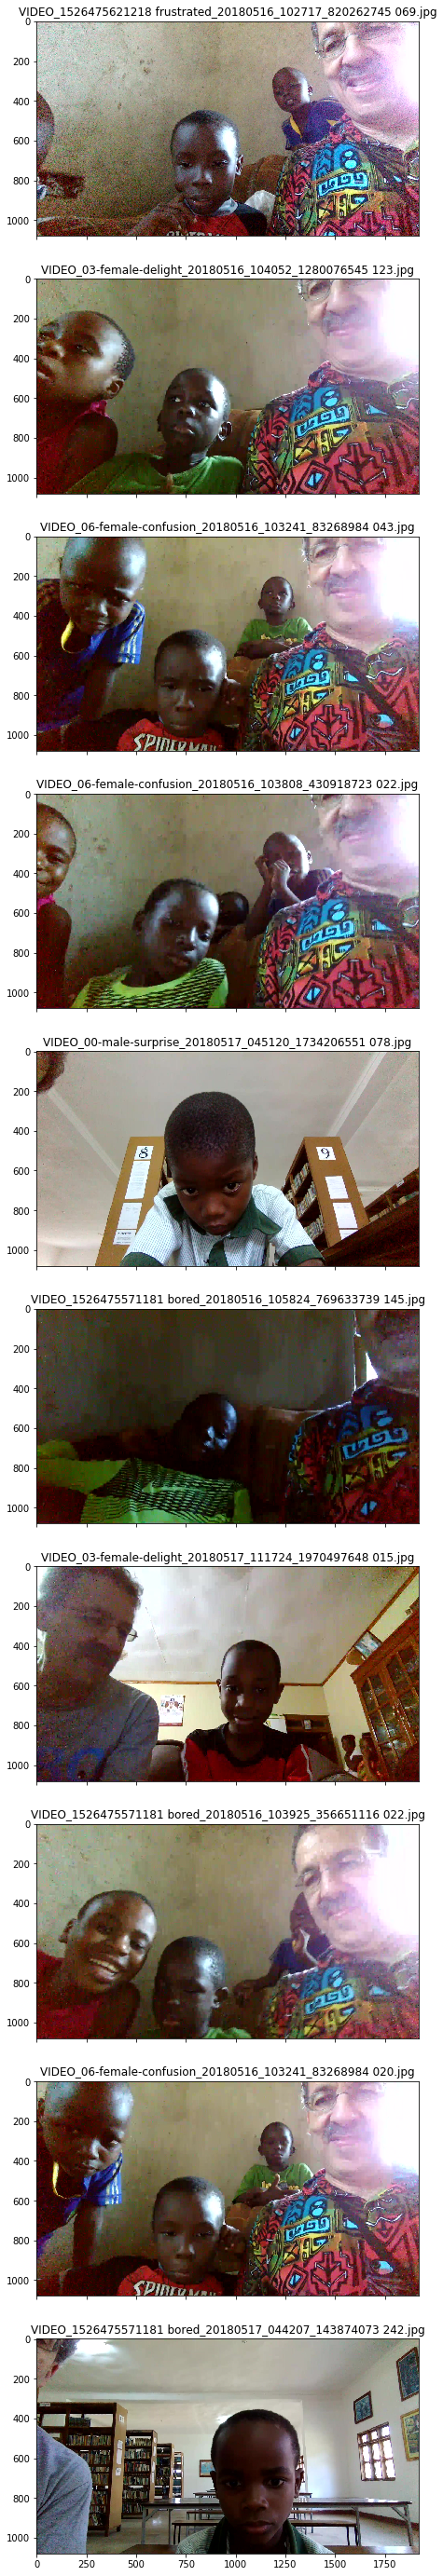

In [23]:
getRandomImages('output_XML/zface-output.xml', images_folder='/media/amogh/Stuff/CMU/datasets/bagamoyo_data/bagamoyo_frames_folder_wise/', has_box=False)

Get 10 random images where face is not detected in an xml file.
Find 10 images 

In [21]:
samp_path=random.sample(frames_list,1)[0]
print(type(samp_path))
image=cv2.imread(samp_path)
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
rects=detector(gray,1)
for i,rect in enumerate(rects):
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 10)
    cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
    # show the face number
#     cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

NameError: name 'frames_list' is not defined

TODO Experiments
- Face detection (2 hrs), try to visualise and understand exactly why HOG isn't working here, try to see the values obtained when similarity across each window is calculated.
    - Try to detect face in cropped images.
    - Try to detect face when background is of same color(try average, white, black).
- See the values in terms of HOG detector, what is going wrong. Read about it and see which visualisations are wrong.